## Run default configurations
Print out Psats, NET, NET_wafer


In [37]:
import glob

In [38]:
# See what yaml files are locally available.
glob.glob('*.yaml')

['CHLAT_20210714.yaml',
 'SAT_HF_20220526.yaml',
 'SAT_LF_20220526.yaml',
 'SAT_MF_20220526.yaml',
 'SPLAT_20210714.yaml']

In [39]:
# Standard imports
import numpy as np
import yaml
import toml
import pprint
import matplotlib
import matplotlib.pyplot as plt
from datetime import datetime
%matplotlib inline  
plt.rcParams.update({'font.size': 18})
plt.rcParams['figure.figsize'] = [12, 20]

# bolo-calc import
from bolo import Top



In [40]:
def print_cam_tables(cam_tables):
    for keyname in cam_tables.keys():
        if 'cam' in keyname:
            print(keyname)
            dat = np.array(cam_tables[keyname])
            print('  Efficiency:         {0:3.2f}'.format(dat[0][0]))
            print('  Optical power (pW): {0:3.2f}'.format(dat[0][1]))
            print('  P_sat (pW):         {0:3.2f}'.format(dat[0][2]))
            print('  F_link:             {0:3.2f}'.format(dat[0][3]))
            print('  G:                  {0:3.2f}'.format(dat[0][4]))
            print('  NEP_bolo:           {0:3.2f}'.format(dat[0][7]))
            print('  NEP_readout:        {0:3.2f}'.format(dat[0][8]))       
            print('  NEP_photon:         {0:3.2f}'.format(dat[0][9]))
            print('  NEP_tot:            {0:3.2f}'.format(dat[0][10]))
            print('  NET_bolo:           {0:3.2f}'.format(dat[0][11]))
            print('  NET_bolo_corr:      {0:3.2f}'.format(dat[0][12]))
            print('  corr_factor:        {0:3.2f}'.format(dat[0][13]))
            print('  NET_wafer (uncorr)  {0:3.2f}'.format(dat[0][14]))
        print()

In [41]:
def print_optical_tables(cam_tables):
    chnames = []
    for chan in cam_tables.keys():
        if chan.split('_')[0] == 'cam' :
            chname = chan.split('_')[2] + '_' + chan.split('_')[3]
            chnames.append(chname)
    
    dat = cam_tables['optical']
    ncams = len(chnames)
    nrows = int(len(dat['channel'])/ncams)

    for n in range(ncams):
        print(chnames[n])
        rows = n*nrows + np.arange(nrows)
        dat['element','elem_effic_mean','elem_power_to_det_mean', 'elem_power_from_sky_mean'][rows].pprint()
        print()

## Run
Read yaml files, run bolo_calc, store some outputs into dictionary called "data".
Print some outputs to table.

In [42]:
data = {}
tops = {}

yamlfiles = ['SAT_LF_20220526.yaml','SAT_MF_20220526.yaml', 'SAT_HF_20220526.yaml' ]
#read fixed PSATs from .toml file
psat_dict = toml.load("FixedPsats.toml")

for yamlfile in yamlfiles:
    print(yamlfile)
    data[yamlfile] = {}
    dd = yaml.safe_load(open(yamlfile))
    version_date = str(dd['version']['date'])
    version_telescope = str(dd['version']['name'])
    print('{0:8s}  Popt(pW) Psat(pW)   NET    NET_wafer  corr_fact'.format(version_telescope))
    del dd['version']

    # location of atmosphere file
    dd['sim_config']['config_dir'] = '../scripts'
    
    ch_names = list(dd['instrument']['camera_config']['elements']['cam_1']['chan_config']['elements'].keys())
    
    #---------
    #convert to Watts
    for channel in ch_names:
        psat_dict[yamlfile.partition('.')[0]][channel] *= 1e-12

    #set psat factor to None & delete psat entry from channel default
    dd['instrument']['channel_default']['psat_factor'] = None
    del dd['instrument']['channel_default']['psat']

    #assign SI psat values at the channel level
    for channel in ch_names:
        dd['instrument']['camera_config']['elements']['cam_1']['chan_config']['elements'][channel]['psat'] = psat_dict[yamlfile.partition('.')[0]][channel]
    #---------
    
    # Save some of the defaults things
    data[yamlfile]['defaults']={}
    data[yamlfile]['defaults']['Yield']=dd['instrument']['channel_default']['Yield']
    data[yamlfile]['defaults']['Tc']=dd['instrument']['channel_default']['Tc']
    data[yamlfile]['defaults']['waist_factor']=dd['instrument']['channel_default']['waist_factor']
    data[yamlfile]['defaults']['read_frac']=dd['instrument']['channel_default']['read_frac']
    data[yamlfile]['defaults']['site']=dd['instrument']['site']
    data[yamlfile]['defaults']['elevation']=dd['instrument']['elevation']
    data[yamlfile]['defaults']['pwv']=dd['instrument']['pwv']

    top = Top(**dd)
    top.run()
    
    tops[yamlfile] = top
    
    for chan in top.instrument.tables.keys():
        if chan.split('_')[0] == 'cam' :
            chname = chan.split('_')[2] + '_' + chan.split('_')[3]
            data[yamlfile][chname] = {}
            
            # Extract the optics table
            dat = top.instrument.tables['optical']
            chans = list(top.instrument.tables.keys())
            try:
                chans.remove('optical')
            except ValueError:
                pass
            
            ncams = len(chans)
            nrows = int(len(dat['channel'])/ncams)
            
            n = chans.index(chan)
            rows = n*nrows + np.arange(nrows)
            data[yamlfile][chname]['optics'] = {}
            
            optics_output = ['elem_effic_mean','elem_power_to_det_mean', 'elem_power_from_sky_mean']
            for r in rows:
                data[yamlfile][chname]['optics'][dat['element'][r]] = {}
                for out in optics_output:
                    data[yamlfile][chname]['optics'][dat['element'][r]][out] = dat[out][r]

            #
            # Grab things we're going to print and give them short names and store them in the dictionary.
            popt = top.instrument.tables[chan]['opt_power'][0]
            data[yamlfile][chname]['popt'] = popt
            psat = top.instrument.tables[chan]['P_sat'][0]
            data[yamlfile][chname]['psat'] = psat
            net = top.instrument.tables[chan]['NET'][0]
            data[yamlfile][chname]['net'] = net
            netwafer = top.instrument.tables[chan]['NET_arr'][0]
            data[yamlfile][chname]['netwafer'] = netwafer
            #
            # Grab things we're not going to print and store them in the dictionary.
            data[yamlfile][chname]['effic'] = top.instrument.tables[chan]['effic'][0]
            data[yamlfile][chname]['nep_photon'] = top.instrument.tables[chan]['NEP_ph'][0]
            data[yamlfile][chname]['nep_phonon'] = top.instrument.tables[chan]['NEP_bolo'][0]
            data[yamlfile][chname]['nep_readout'] = top.instrument.tables[chan]['NEP_read'][0]
            data[yamlfile][chname]['Gdyn'] = top.instrument.tables[chan]['G'][0]
            corr_fact = top.instrument.tables[chan]['corr_fact'][0]
            data[yamlfile][chname]['corr_fact'] = corr_fact 
            data[yamlfile][chname]['bandcenter'] = dd['instrument']['camera_config']['elements']['cam_1']['chan_config']['elements'][chname]['band_center']
            data[yamlfile][chname]['fractional_bandwidth'] = dd['instrument']['camera_config']['elements']['cam_1']['chan_config']['elements'][chname]['fractional_bandwidth']
            dnu = 0.5*data[yamlfile][chname]['bandcenter']*data[yamlfile][chname]['fractional_bandwidth']
            data[yamlfile][chname]['band_lowedge'] = data[yamlfile][chname]['bandcenter'] - dnu
            data[yamlfile][chname]['band_highedge'] = data[yamlfile][chname]['bandcenter'] + dnu
            print('{0:5s} : {1:8.2f} {2:8.2f} {3:8.2f} {4:8.2f} {5:8.2f}'.format(chname,popt,psat,net,netwafer,corr_fact) )
    print(' ')
    

SAT_LF_20220526.yaml
SAT_LF    Popt(pW) Psat(pW)   NET    NET_wafer  corr_fact
LF_1  :     0.52     1.30   147.45    33.65     1.04
LF_2  :     2.13     5.32   190.05    43.37     1.01
 
SAT_MF_20220526.yaml
SAT_MF    Popt(pW) Psat(pW)   NET    NET_wafer  corr_fact
MF1_1 :     2.52     6.11   250.59    16.34     1.03
MF1_2 :     2.97     7.54   213.28    13.91     1.00
MF2_1 :     2.37     6.11   205.73    12.51     1.02
MF2_2 :     3.06     7.54   223.96    13.62     1.00
 
SAT_HF_20220526.yaml
SAT_HF    Popt(pW) Psat(pW)   NET    NET_wafer  corr_fact
HF_1  :     6.20    15.51   459.67    16.78     1.01
HF_2  :     8.06    20.16  1126.74    41.13     1.00
 


In [43]:
for yamlfile in yamlfiles:
    print(yamlfile)
    print_cam_tables(tops[yamlfile].instrument.tables)

SAT_LF_20220526.yaml
cam_1_LF_1_sims
  Efficiency:         0.45
  Optical power (pW): 0.52
  P_sat (pW):         1.30
  F_link:             0.52
  G:                  36.47
  NEP_bolo:           5.20
  NEP_readout:        3.33
  NEP_photon:         9.02
  NEP_tot:            10.94
  NET_bolo:           147.45
  NET_bolo_corr:      152.85
  corr_factor:        1.04
  NET_wafer (uncorr)  33.65

cam_1_LF_2_sims
  Efficiency:         0.48
  Optical power (pW): 2.13
  P_sat (pW):         5.32
  F_link:             0.52
  G:                  149.33
  NEP_bolo:           10.52
  NEP_readout:        9.15
  NEP_photon:         26.56
  NEP_tot:            29.99
  NET_bolo:           190.05
  NET_bolo_corr:      191.40
  corr_factor:        1.01
  NET_wafer (uncorr)  43.37


SAT_MF_20220526.yaml
cam_1_MF1_1_sims
  Efficiency:         0.41
  Optical power (pW): 2.52
  P_sat (pW):         6.11
  F_link:             0.52
  G:                  171.49
  NEP_bolo:           11.27
  NEP_readout:        

In [44]:
for t, top in tops.items():
    print_optical_tables(top.instrument.tables)

LF_1
  element     elem_effic_mean   elem_power_to_det_mean elem_power_from_sky_mean
------------ ------------------ ---------------------- ------------------------
         cmb                1.0    0.11492820524768763                      0.0
        dust                1.0 4.2279542310596077e-17    9.300450289992005e-17
 synchrotron                1.0  4.461159061563834e-12    9.802741156029342e-12
  atmosphere 0.9839788328922576     0.1962565144760821       0.4246866653914209
      baffle 0.9900000000000009    0.14917791835522756       0.7322575442602343
      window 0.9895112525670474   0.007441669995524475       0.7405525536708778
    RTMLI_10 0.9960100000000014    0.03312186412234843       0.8019751987877535
alumina_filt 0.9750937898974739   0.014087172567808766        0.827661218118418
  nylon_filt 0.9897030000000013  5.897877980019029e-05       0.8071481382769956
       lens1 0.9754285204279718   0.000138736507520086       0.7991098096895228
      ApStop 0.8699999999999991   0

## Make a 4-panel plot.
Popt, Psat, NET, NET_wafer

Text(0.5, 1.0, '20220526')

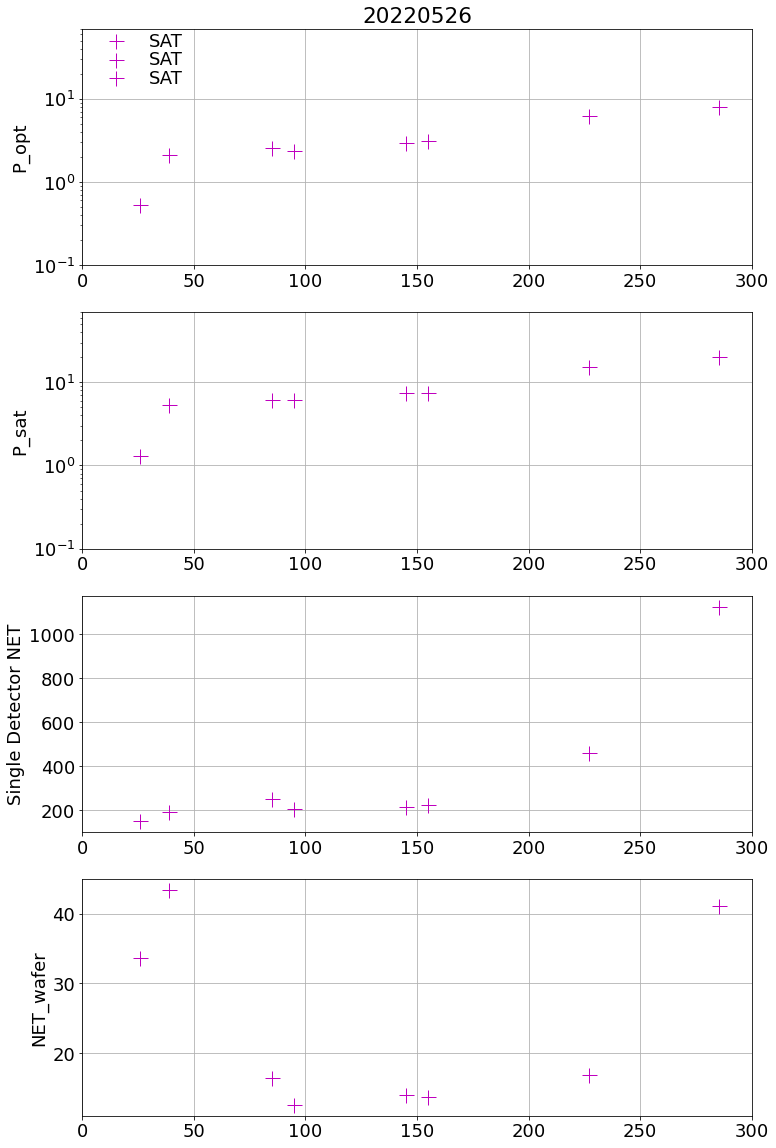

In [45]:
# Plot things vs frequency for each telescope

# Set up a 4-panel plot
plt.clf()
ax1=plt.subplot(4,1,1)
ax1.set_ylabel('P_opt')
ax1.set_xlim(0,300)
ax1.set_ylim(0.1,70)
ax1.grid()
#
ax2=plt.subplot(4,1,2)
ax2.set_ylabel('P_sat')
ax2.set_xlim(0,300)
ax2.set_ylim(0.1,70)
ax2.grid()
#
ax3=plt.subplot(4,1,3)
ax3.set_ylabel('Single Detector NET')
ax3.set_xlim(0,300)
ax3.grid()
#
ax4=plt.subplot(4,1,4)
ax4.set_ylabel('NET_wafer')
ax4.set_xlim(0,300)
ax4.grid()
yfrac = 0.7

for yamlfile in yamlfiles: 
    telescope = yamlfile.split('_')[0]
    if telescope == 'CHLAT':
        pointtype = '.r'
    elif telescope == 'SPLAT':
        pointtype = '.b'
    else:
        pointtype = '+m'
    
    for chname in data[yamlfile].keys():
        if chname != 'defaults':
            nu = data[yamlfile][chname]['bandcenter']
            #
            ax1.semilogy(nu, data[yamlfile][chname]['popt'],pointtype, markersize=15 )
            ax2.semilogy(nu, data[yamlfile][chname]['psat'],pointtype, markersize=15 )
            ax3.plot(nu, data[yamlfile][chname]['net'],pointtype, markersize=15 )
            ax4.plot(nu, data[yamlfile][chname]['netwafer'],pointtype, markersize=15 )
            #
    
    ymin,ymax = ax1.set_ylim()
    xmin,xmax = ax1.set_xlim()
    xval = xmin+0.05*(xmax-xmin)
    yval = ymin+yfrac*(ymax-ymin)
    ax1.semilogy(xval, yval, pointtype, markersize=15)
    ax1.text(xval+0.05*(xmax-xmin), yval, telescope, verticalalignment='center')
    yfrac = yfrac*0.6


ax1.grid()
ax1.grid()
ax1.set_title(version_date)
    

## Make a 4-panel plot.
efficiency, NEP_photon, NEP_phonon, NEP_readout

Text(0.5, 1.0, '20220526')

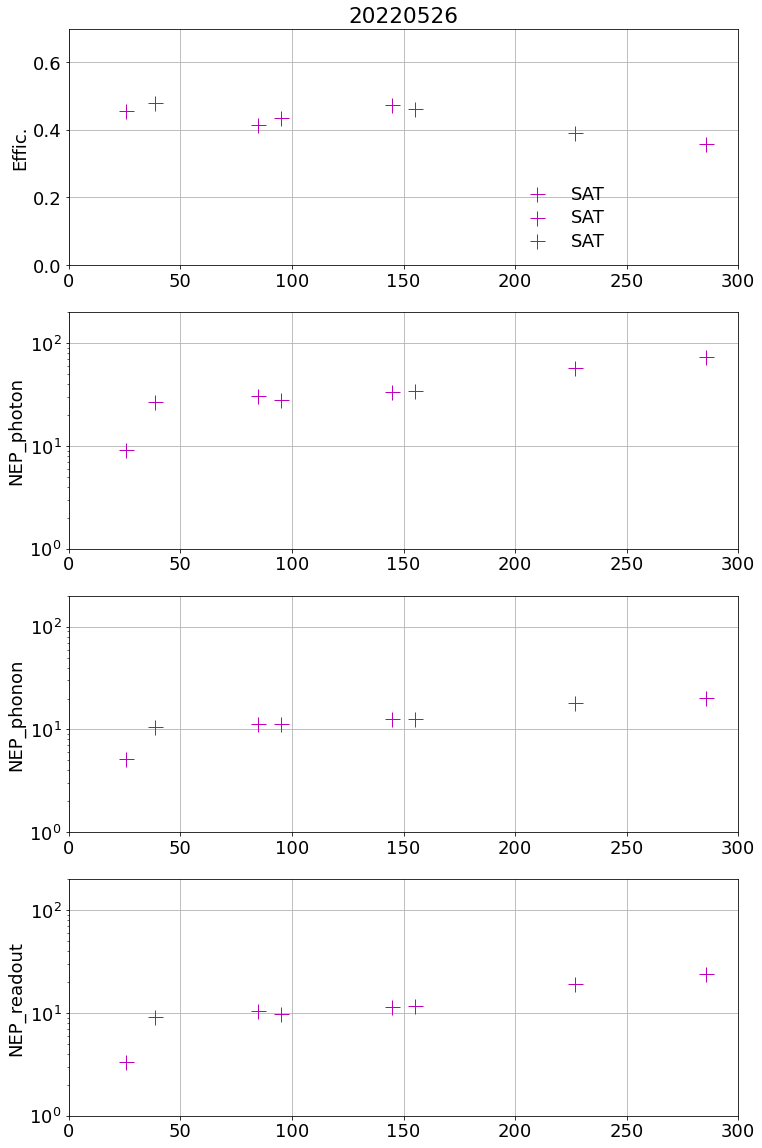

In [46]:
plt.clf()
ax1=plt.subplot(4,1,1)
ax1.set_ylabel('Effic.')
ax1.set_xlim(0,300)
ax1.set_ylim(0,0.7)
ax1.grid()
#
ax2=plt.subplot(4,1,2)
ax2.set_ylabel('NEP_photon')
ax2.set_xlim(0,300)
ax2.set_ylim(1,200)
ax2.grid()
#
ax3=plt.subplot(4,1,3)
ax3.set_ylabel('NEP_phonon')
ax3.set_xlim(0,300)
ax3.set_ylim(1,200)
ax3.grid()
#
ax4=plt.subplot(4,1,4)
ax4.set_ylabel('NEP_readout')
ax4.set_xlim(0,300)
ax4.set_ylim(1,200)
ax4.grid()

#data = {}
yfrac = 0.3

for yamlfile in yamlfiles: 
    telescope = yamlfile.split('_')[0]
    if telescope == 'CHLAT':
        pointtype = '.r'
    elif telescope == 'SPLAT':
        pointtype = '.b'
    else:
        pointtype = '+m'
    
    for chname in data[yamlfile].keys():
        if chname != 'defaults':
            nu = data[yamlfile][chname]['bandcenter']
            #
            ax1.plot(nu, data[yamlfile][chname]['effic'],pointtype, markersize=15 )
            ax2.semilogy(nu, data[yamlfile][chname]['nep_photon'],pointtype, markersize=15 )
            ax3.semilogy(nu, data[yamlfile][chname]['nep_phonon'],pointtype, markersize=15 )
            ax4.semilogy(nu, data[yamlfile][chname]['nep_readout'],pointtype, markersize=15 )

    
    ymin,ymax = ax1.set_ylim()
    xmin,xmax = ax1.set_xlim()
    xval = xmin+0.7*(xmax-xmin)
    yval = ymin+yfrac*(ymax-ymin)
    ax1.plot(xval,yval,pointtype,markersize=15)
    ax1.text(xval+0.05*(xmax-xmin),yval,telescope,verticalalignment='center')
    yfrac = yfrac-0.1


ax1.grid()
ax1.grid()
ax1.set_title(version_date)



In [47]:
# Write to files
data['runtime'] = datetime.today().strftime('%Y/%m/%d %H:%M:%S')
data['input_id'] = version_date
data['variation'] = 'BaseModel'

# Write to toml file
output_file_name = data['variation'] + '.toml'
with open('outputs/' + output_file_name, "w") as toml_file:
    toml.dump(data, toml_file, encoder=toml.TomlNumpyEncoder())

# Explore data

In [48]:
pprint.pprint(data)

{'SAT_HF_20220526.yaml': {'HF_1': {'Gdyn': 435.00362431996723,
                                   'band_highedge': 256.056,
                                   'band_lowedge': 197.944,
                                   'bandcenter': 227.0,
                                   'corr_fact': 1.0056538194910032,
                                   'effic': 0.38973549936900687,
                                   'fractional_bandwidth': 0.256,
                                   'nep_phonon': 17.952170291052735,
                                   'nep_photon': 56.837430396823564,
                                   'nep_readout': 19.082959047484067,
                                   'net': 459.67157758761266,
                                   'netwafer': 16.780358640086675,
                                   'optics': {'ApStop': {'elem_effic_mean': 0.8750000000000019,
                                                         'elem_power_from_sky_mean': 11.10729438062464,
                        